In [2]:
import scipy.io
import scipy.spatial
import scipy.interpolate

import matplotlib.pyplot as plt
import os

import numpy as np

import sklearn
import pandas as pd

from os import listdir
from os.path import isfile, join

import datafold.dynfold as dfold
import datafold.pcfold as pfold

from large_eigensystems import *

599.6003229166666 599.98
588.64321875 599.98
599.3121875 599.98
599.9643645833333 599.98


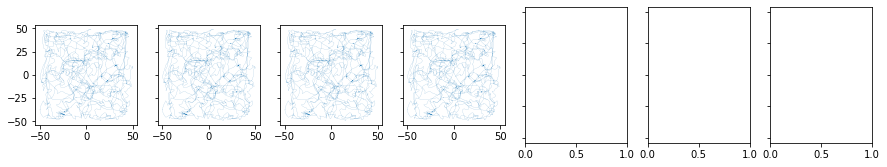

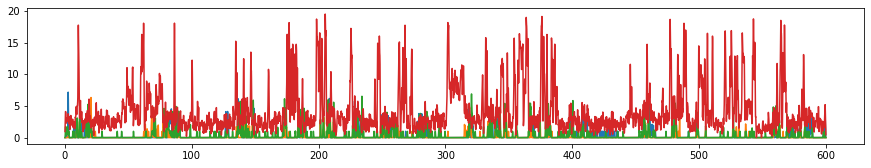

In [3]:
basepath = r"C:\Users\felix\Documents\local data dump\rat brain data files grid cells"
filepath_positions = os.path.join(basepath, "sargolini2006")
filepath_eeg = os.path.join(basepath, "sargolini2006/all_data")

filenames = [f for f in listdir(filepath_positions)
                 if isfile(join(filepath_positions, f)) and "11084" in f and ".mat" in f[-5:]]

def spike(bins, spiketime, sigma=1):
    _d = scipy.spatial.distance.cdist(bins, spiketime)
    return np.sum(np.exp(-_d**2/sigma), axis=1)

data_length_cutoff_time = 600
n_skip = 2
spike_bins = np.linspace(0,data_length_cutoff_time,20000).reshape(-1,1)
spike_sigma = (spike_bins[1,] - spike_bins[0,])/1

fig, ax = plt.subplots(1,len(filenames),figsize=(15,2.5),sharey=True)
fig2, ax2 = plt.subplots(1,1,figsize=(15,2.5),sharey=True)

data_normed_spikes = []
data_normed_positions = []

filenames = filenames[2:6]


plot_idx=0
for filename in filenames:
    mat = scipy.io.loadmat(os.path.join(filepath_positions, filename))
    
    # print(mat.keys())
    print(np.max(mat['ts']), np.max(mat['t']))

    ax[plot_idx].plot(mat['x1'], mat['y1'], linewidth=.1)
    ax[plot_idx].set_aspect(1)
    plot_idx+=1
    
    idx_t = mat["t"] < data_length_cutoff_time
    idx_ts = mat["ts"] < data_length_cutoff_time
    idx_t[::n_skip] = False
    idx_ts[::n_skip] = False
    
    current_spikes = spike(spike_bins, mat["ts"][idx_ts].reshape(-1,1),spike_sigma)
    current_x = scipy.interpolate.interp1d(mat['t'][idx_t,], mat['x1'][idx_t,], fill_value='extrapolate')
    current_y = scipy.interpolate.interp1d(mat['t'][idx_t,], mat['y1'][idx_t,], fill_value='extrapolate')
    current_positions = np.column_stack([current_x(spike_bins[:,0]), current_y(spike_bins[:,0])])
    
    data_normed_spikes.append(current_spikes)
    data_normed_positions.append(current_positions)
    
    ax2.plot(spike_bins, current_spikes)


In [27]:
data_normed_spikes_full = np.row_stack(data_normed_spikes).T
data_normed_positions_full = np.row_stack(data_normed_positions)

#data_normed_spikes_full = data_normed_spikes_full / np.max(data_normed_spikes_full, axis=0)
data_normed_positions_full = data_normed_positions_full[0:data_normed_spikes_full.shape[0],:]

n_delays = 10

# setup processing pipeline and fit
data_pipe = sklearn.pipeline.Pipeline([
    (
        "takens",
        dfold.TSCTakensEmbedding(delays=n_delays),
    ),
    (
        "pca2",
        dfold.TSCPrincipalComponent(n_components=20),
    ),
])

# process spikes
df = pd.DataFrame(data_normed_spikes_full, index=np.arange(data_normed_spikes_full.shape[0]))
tsc = pfold.TSCDataFrame.from_single_timeseries(df)
data_pipe.fit(tsc)
components = data_pipe.transform(tsc)
data_normed_spikes_windows = np.array(components)

# process positions
# df = pd.DataFrame(data_normed_positions_full, index=np.arange(data_normed_positions_full.shape[0]))
# tsc = pfold.TSCDataFrame.from_single_timeseries(df)
# data_pipe.fit(tsc)
# components = data_pipe.transform(tsc)
# data_normed_positions_windows = np.array(components)
data_normed_positions_windows = data_normed_positions_full[data_normed_positions_full.shape[0]-data_normed_spikes_windows.shape[0]:,:]

# reduce data size
#pcm = pfold.PCManifold(data_normed_positions_windows)
#pcm.optimize_parameters()
#_, indices = pfold.pcm_subsample(pcm, n_samples=10000, min_distance=pcm.cut_off*10)

#data_normed_spikes_sampled = data_normed_spikes_windows[indices,:]
#data_normed_positions_sampled = data_normed_positions_windows[indices,:]

data_normed_spikes_sampled = data_normed_spikes_windows[::2,:]
data_normed_positions_sampled = data_normed_positions_windows[::2,:]

print(data_normed_spikes_full.shape)
print(data_normed_positions_full.shape)
print(data_normed_spikes_sampled.shape)
print(data_normed_positions_sampled.shape)

(20000, 4)
(20000, 2)
(9995, 20)
(9995, 2)


In [28]:
# now try to find good coordinates using the jointly smooth functions

# "sensor 1"
sensordata_1 = data_normed_spikes_sampled.copy()
# "sensor 2"
sensordata_2 = data_normed_positions_sampled.copy()

def compute_evecs(_data, _n_evecs, kernel_type="gaussian"):
    print(f"Computing {_n_evecs} eigenvectors for data of size {_data.shape}...", end=" ")
    
    pcm = pfold.PCManifold(_data)
    pcm.optimize_parameters(result_scaling=10)
    
    if kernel_type == "cknn":
        kernel = pfold.ContinuousNNKernel(delta=1.0, k_neighbor=25)
        dist_kwargs = {"backend": "scipy.kdtree", "cut_off": pcm.cut_off, "kmin": kernel.k_neighbor}
        res, _ = kernel(_data, dist_kwargs=dist_kwargs)
    else:
        kernel = pcm.kernel
        dist_kwargs = {"backend": "scipy.kdtree", "cut_off": pcm.cut_off}
        res = kernel(_data, dist_kwargs=dist_kwargs)
        
    print("Optimized parameters...", end=" ")
    
    res = 1/2 * scipy.sparse.csr_matrix(res + res.T)
    #res = scipy.sparse.diags(np.sqrt(np.array(1/res.sum(axis=0))).ravel(), 0) @ res @ scipy.sparse.diags(np.sqrt(np.array(1/res.sum(axis=0))).ravel(), 0)
    res = scipy.sparse.diags(np.array(1/res.sum(axis=0)).ravel(), 0) @ res
    res.eliminate_zeros()
    
    Aevals,Aevecs = scipy.sparse.linalg.eigsh(res, k=_n_evecs, which="LM")
    evals_,evecs_ = CommonEigensystemMatrix._sort_eigensystem(None, Aevals, Aevecs)
    
    print("Done.")
    return evecs_, evals_

n_kernel_evecs = 1000

# eigenvectors 1
evecs1, evals1 = compute_evecs(sensordata_1, _n_evecs=n_kernel_evecs, kernel_type="gaussian")
# eigenvectors 2
evecs2, evals2 = compute_evecs(sensordata_2, _n_evecs=n_kernel_evecs, kernel_type="gaussian")

Computing 1000 eigenvectors for data of size (9995, 20)... Optimized parameters... Done.
Computing 1000 eigenvectors for data of size (9995, 2)... Optimized parameters... Done.


In [29]:
n_common_evecs = 10
evecs_c, evals_c, _ = scipy.linalg.svd(np.column_stack([evecs1, evecs2]))
evals_c, evecs_c = CommonEigensystemMatrix._sort_eigensystem(None, evals_c, evecs_c)

evecs_c = evecs_c[:,:n_common_evecs]
evals_c = evals_c[:n_common_evecs]
print(evals_c)

[1.41421356 1.39641017 1.39513314 1.39364226 1.39178567 1.38983802
 1.38780001 1.38678234 1.38314353 1.38216556]


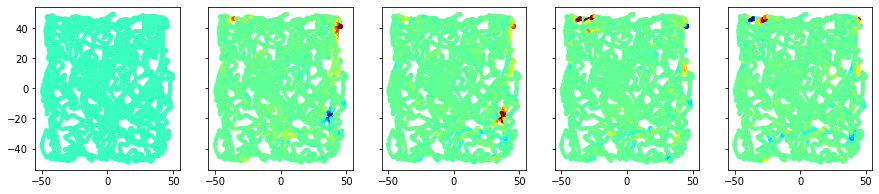

In [35]:
vmin,vmax = np.min(evecs_c)/3, np.max(evecs_c)/3

fig,ax = plt.subplots(1,5,figsize=(15,3),sharey=True)
for k in range(len(ax)):
    ax[k].scatter(*data_normed_positions_sampled[:evecs_c.shape[0],[0,1]].T, s=10, c=evecs_c[:,k+0], vmin=vmin,vmax=vmax, cmap="jet")

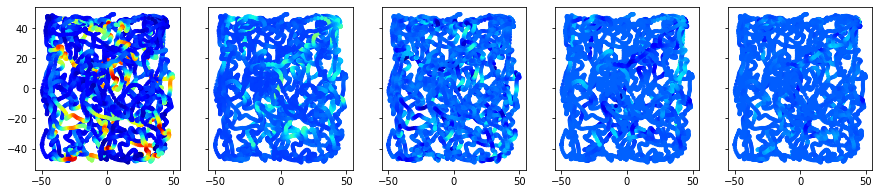

In [37]:
vmin,vmax = np.min(data_normed_spikes_sampled)/1, np.max(data_normed_spikes_sampled)/1

fig,ax = plt.subplots(1,5,figsize=(15,3),sharey=True)
for k in range(len(ax)):
    ax[k].scatter(*data_normed_positions_sampled[:evecs_c.shape[0],[0,1]].T, s=10, c=data_normed_spikes_sampled[:,k+0], vmin=vmin,vmax=vmax, cmap="jet")

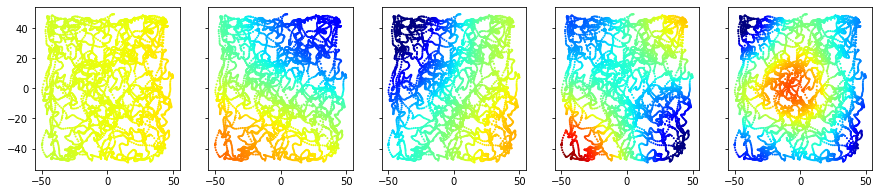

In [32]:
vmin,vmax = np.min(evecs2)/5, np.max(evecs2)/5

fig,ax = plt.subplots(1,5,figsize=(15,3),sharey=True)
for k in range(len(ax)):
    ax[k].scatter(*data_normed_positions_sampled[:evecs_c.shape[0],[0,1]].T, s=1, c=evecs2[:,k+0], vmin=vmin,vmax=vmax, cmap="jet")

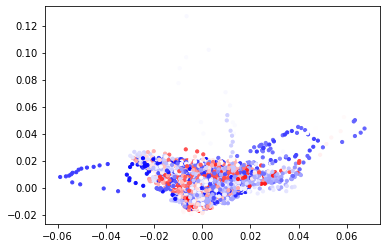

In [11]:
fig,ax = plt.subplots(1,1)
ax.scatter(*evecs_c[:,[2,1]].T, s=10, c=data_normed_positions_sampled[:,1], cmap="bwr")

In [74]:
lrs = dfold.LocalRegressionSelection(n_subsample=500, intrinsic_dim=5)
lrs.fit(evecs_c)

print(lrs.evec_indices_)

[1 2 3 5 7]
